<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Задача - спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания, которая будет учиться на метрике *RMSE*. Будем считать, что модель выполняет свою задачу при показателе <= 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, cv, Pool

import scipy
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

display(df.head(10), df.info(), df.describe(), df.shape, df.index.min(), df.index.max())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


(26496, 1)

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

Итого: в исходных данных содержатся количество заказов `num_orders` за каждые 10 минут `datetime` практически за 7 месяцев. Мы предварительно определили признак `datetime` как дату и сделали его индексовым. 

Проверим временные промежутки на последовательность:

In [3]:
display(df.index.is_monotonic)

True

Ресемплируем данные по условию задания по 1-му часу:

In [4]:
df = df.resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Расширим исходный набор данных, создадав несколько новых признаков. Этими признаками будут: признак месяца, дня недели, часа. Также, создадим 5 лагов и признак скользящего среднего:

In [5]:
def make_features(df, max_lag, rolling_size):
    
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for i in range(1, max_lag+1):
        df['lag_{}'.format(i)] = df['num_orders'].shift(i)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()

In [6]:
make_features(df, 5, 30)
display(df.head(10), df.shape, df.isna().sum())

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,NaN


(4416, 9)

num_orders       0
dayofweek        0
hour             0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
rolling_mean    30
dtype: int64

В результате сдвигов, образовались пропуски в первых строчках данных. Удалим их, не нарушая последовательности временного ряда:

In [7]:
df = df.dropna()
df.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,
2018-03-02 06:00:00,11,4,6,11.0,20.0,64.0,75.0,120.0,58.133333
2018-03-02 07:00:00,7,4,7,11.0,11.0,20.0,64.0,75.0,54.366667
2018-03-02 08:00:00,46,4,8,7.0,11.0,11.0,20.0,64.0,51.766667
2018-03-02 09:00:00,45,4,9,46.0,7.0,11.0,11.0,20.0,50.933333
2018-03-02 10:00:00,54,4,10,45.0,46.0,7.0,11.0,11.0,50.233333
2018-03-02 11:00:00,91,4,11,54.0,45.0,46.0,7.0,11.0,50.600000
2018-03-02 12:00:00,36,4,12,91.0,54.0,45.0,46.0,7.0,53.433333
2018-03-02 13:00:00,45,4,13,36.0,91.0,54.0,45.0,46.0,54.233333
2018-03-02 14:00:00,44,4,14,45.0,36.0,91.0,54.0,45.0,55.233333


**Вывод:** данные загружены и подготовлены, признак времени проверен на последовательность, выполнена процедура ресемплирования. Созданы новые признаки для наших данных.

Можно провести анализ временного ряда.

## Анализ

Построим график на основе изначальных данных:

<AxesSubplot:xlabel='datetime'>

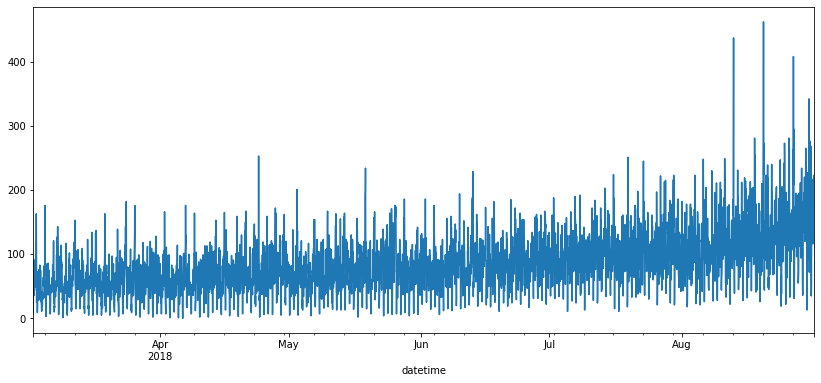

In [8]:
%matplotlib inline
df['num_orders'].plot(figsize=(14, 6))

Данные имеют небольшое количество выбросов, и некоторый тренд ближе к концу временного ряда, что может говорить о том, что ряд может не являтся стационарным. Свойство стационарности необходимо для более точного прогнозирования. Также можно отметить, что в основном пики наблюдаются во временном промежутке от позднего вечера до ночи-раннего утра. Возможно это связано с высокой потребностью в такси в те дни, когда люди отдыхают.

Заменим выбросы соседним значением:

In [9]:
df.shape

(4386, 9)

In [10]:
df.loc[(df.num_orders > 284), 'num_orders'] = np.nan

In [11]:
df = df.fillna(method='ffill')

In [12]:
df.isna().sum()

num_orders      0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
rolling_mean    0
dtype: int64

In [13]:
df.shape

(4386, 9)

________________________________________________________________________________

count    4386.000000
mean       84.439580
std        44.161475
min         0.000000
25%        54.000000
50%        78.000000
75%       108.000000
max       281.000000
Name: num_orders, dtype: float64

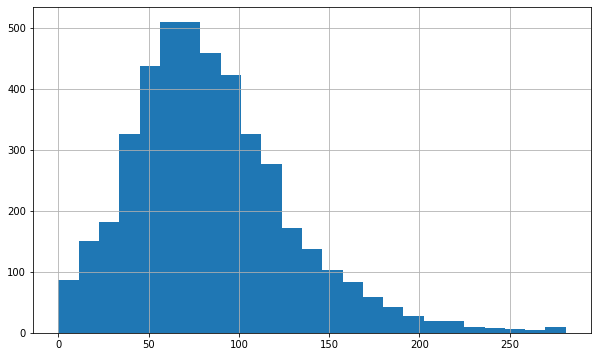

In [14]:
df['num_orders'].hist(bins=25, figsize=(10, 6))
df['num_orders'].describe()

In [15]:
stat, p = scipy.stats.shapiro(df) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.943, p-value=0.000
Отклонить гипотезу о нормальности


C:\Users\SpecialOne\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [16]:
decompose = seasonal_decompose(df['num_orders'])
others = decompose.resid
others.isna().sum()
others = others.dropna()

In [17]:
stat, p = scipy.stats.shapiro(others) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.977, p-value=0.000
Отклонить гипотезу о нормальности


_________________________________________________________

Изначально, мы предположили, что ряд может являться не стационарным. Проверим это статистически и проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Возьмем функцию `adfuller()` из модуля `statsmodels`:

In [18]:
test = sm.tsa.adfuller(df['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -2.971046117484657
p-value:  0.03768823200605471
Critical values:  {'1%': -3.4318524474416483, '5%': -2.862203897664062, '10%': -2.5671233972458647}
единичных корней нет, ряд стационарен


Итак, ряд оказался стационарным, что пойдет на руку нашему исследованию и качество прогнозирования окажется лучше.

Проанализируем "скользящее среднее":

<AxesSubplot:xlabel='datetime'>

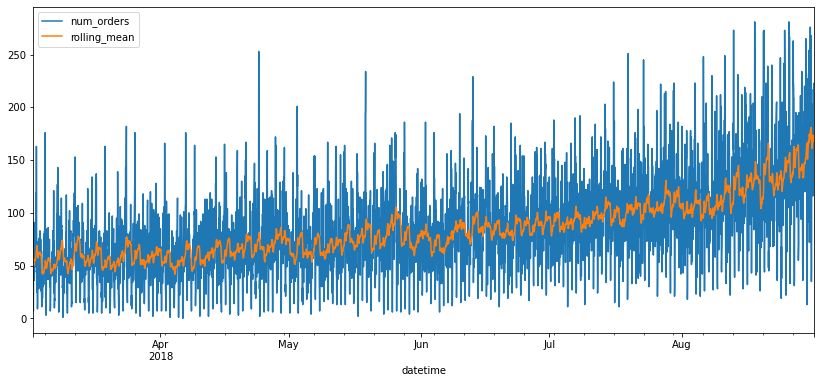

In [19]:
df[['num_orders', 'rolling_mean']].plot(figsize=(14, 6))

Все явнее прослеживается тенденция к росту количества заказов к концу августа. Декомпозируем наш временной ряд - взглянем на графики тренда, сезонности и остатков:

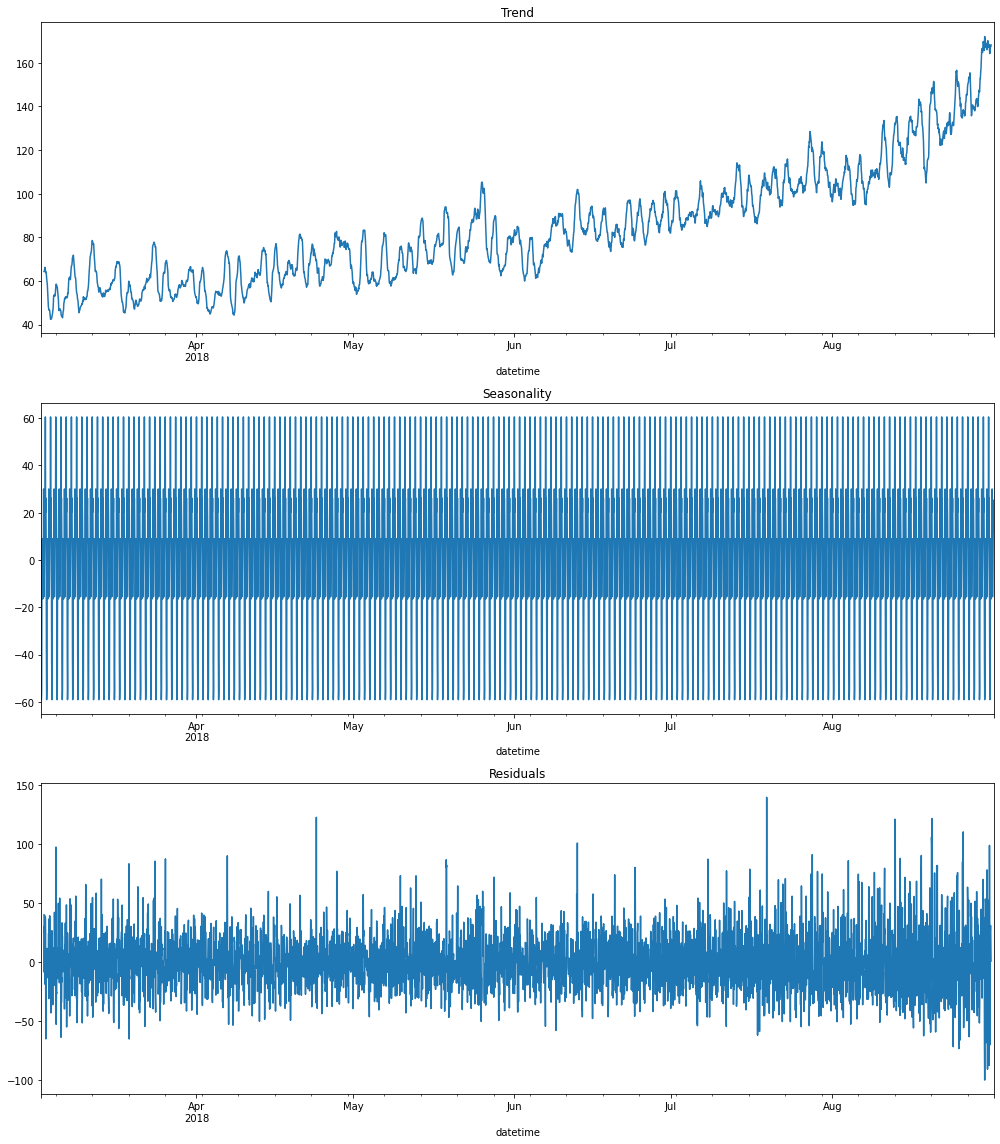

In [20]:
plt.figure(figsize=(14, 16))
plt.subplot(311)
decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Построим график сезонности в рамках двух недель июня:

<IPython.core.display.Javascript object>


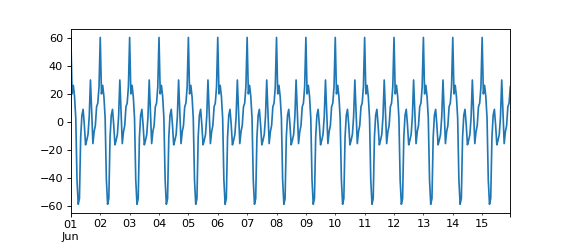

<AxesSubplot:xlabel='datetime'>

In [21]:
%matplotlib notebook
plt.figure(figsize=(7, 3))

decompose.seasonal['2018-06-01': '2018-06-15'].plot()

А также в рамках одного дня:

<IPython.core.display.Javascript object>


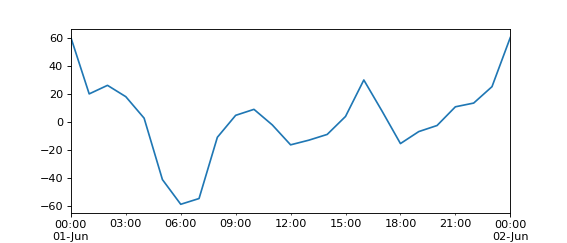

<AxesSubplot:xlabel='datetime'>

In [22]:
plt.figure(figsize=(7, 3))

decompose.seasonal['2018-06-01 00': '2018-06-02 00'].plot()

Как мы изначально предположили, пики по количеству заказов наблюдаются в ранее утро и поздний вечер-ночь. В условно рабочее время активность мала.

**Вывод:** мы провели анализ первичных данных и можно сделать вывод, что данные готовы к построению моделей на их основе. Данные являются стационарными, очищенными от выбросов и пропущенных значений. Наблюдается небольшая тенденция к росту количества заказов с апреля по май и решительный рост за все три месяца лета. Самый резкий скачок происходит за август.

## Обучение

In [23]:
model = []
RMSE = []
train_time = []
predict_time = []

def list_append(model_name, metric, time_1, time_2):
    model.append(model_name)
    RMSE.append(metric)
    train_time.append(time_1)
    predict_time.append(time_2)

Разделим датасет на тренировочную, валидационную и тестовую выборки, указав параметр `shuffle=False` для последовательности данных временного ряда:

In [24]:
state = np.random.RandomState(12345)
target = 'num_orders'

df_train, df_tmp = train_test_split(df, test_size=0.2, shuffle=False, random_state=state)
df_valid, df_test = train_test_split(df_tmp, train_size=0.5, shuffle=False, random_state=state)
X_train, X_valid, X_test = (df_train.drop([target], axis=1), 
                            df_valid.drop([target], axis=1),
                            df_test.drop([target], axis=1),
                           )
y_train, y_valid, y_test = df_train[target], df_valid[target], df_test[target]

display(X_train.tail(), X_valid, X_test.head())

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-07-26 05:00:00,3,5,131.0,141.0,197.0,73.0,149.0,110.533333
2018-07-26 06:00:00,3,6,83.0,131.0,141.0,197.0,73.0,109.633333
2018-07-26 07:00:00,3,7,21.0,83.0,131.0,141.0,197.0,104.966667
2018-07-26 08:00:00,3,8,39.0,21.0,83.0,131.0,141.0,103.800000
2018-07-26 09:00:00,3,9,80.0,39.0,21.0,83.0,131.0,101.633333


,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-07-26 10:00:00,3,10,138.0,80.0,39.0,21.0,83.0,101.500000
2018-07-26 11:00:00,3,11,142.0,138.0,80.0,39.0,21.0,102.100000
2018-07-26 12:00:00,3,12,86.0,142.0,138.0,80.0,39.0,102.666667
2018-07-26 13:00:00,3,13,102.0,86.0,142.0,138.0,80.0,103.900000
2018-07-26 14:00:00,3,14,70.0,102.0,86.0,142.0,138.0,104.233333
...,...,...,...,...,...,...,...,...
2018-08-13 12:00:00,0,12,144.0,156.0,137.0,91.0,39.0,126.566667
2018-08-13 13:00:00,0,13,92.0,144.0,156.0,137.0,91.0,128.900000
2018-08-13 14:00:00,0,14,119.0,92.0,144.0,156.0,137.0,132.066667


,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-08-13 17:00:00,0,17,144.0,175.0,102.0,119.0,92.0,135.666667
2018-08-13 18:00:00,0,18,152.0,144.0,175.0,102.0,119.0,138.033333
2018-08-13 19:00:00,0,19,104.0,152.0,144.0,175.0,102.0,137.400000
2018-08-13 20:00:00,0,20,91.0,104.0,152.0,144.0,175.0,136.433333
2018-08-13 21:00:00,0,21,82.0,91.0,104.0,152.0,144.0,135.700000


Соотнесем концы и начала данных по временному индексу и убедимся, что данные разделены корректно. Теперь построим пайплайн для подбора модели обучения:

In [25]:
def pipe_model(name, model):
    timer_begin = time.time()

    pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('model', model)
    ])
    pipe.fit(X_train, y_train)

    timer_end = time.time()
    train_timer = timer_end - timer_begin

    timer_begin = time.time()

    pred = pipe.predict(X_valid)
    rmse = mean_squared_error(y_valid, pred)**0.5
    
    timer_end = time.time()
    predict_timer = timer_end - timer_begin
    
    list_append(name, rmse, train_timer, predict_timer)
    print('Затраченное время: %f ms' % train_timer)
    print('Затраченное время: %f ms' % predict_timer)
    print('RMSE: ', rmse)
    
    return pipe

Создадим статичную модель `DummyRegression` для проверки других моделей на адекватность и интерпретируемости результата метрики:

In [26]:
pipe_model('DummyRegression', DummyRegressor(strategy="mean"))

Затраченное время: 0.011692 ms
Затраченное время: 0.002000 ms
RMSE:  56.60006554965278


Pipeline(steps=[('scale', StandardScaler()), ('model', DummyRegressor())])

Теперь обучим тестовые модели для дальнейшего выбора лучшей. Сравнивать будем: `LinearRegression`, `CatBoostRegressor` и `LGBMResgressor`:

In [27]:
pipe_model('LinearRegression', LinearRegression())

Затраченное время: 0.012001 ms
Затраченное время: 0.003000 ms
RMSE:  39.262574705635785


Pipeline(steps=[('scale', StandardScaler()), ('model', LinearRegression())])

In [28]:
cat = CatBoostRegressor(
   depth=9,
    loss_function='RMSE',
   iterations=500,
    verbose=10)
pipe_model('Cat', cat)

Learning rate set to 0.087707
0:	learn: 34.3915518	total: 152ms	remaining: 1m 15s
10:	learn: 26.4015456	total: 276ms	remaining: 12.3s
20:	learn: 23.0033074	total: 401ms	remaining: 9.15s
30:	learn: 21.4514542	total: 521ms	remaining: 7.89s
40:	learn: 20.4432427	total: 645ms	remaining: 7.22s
50:	learn: 19.6361614	total: 770ms	remaining: 6.78s
60:	learn: 19.0303883	total: 889ms	remaining: 6.39s
70:	learn: 18.4745293	total: 1.01s	remaining: 6.1s
80:	learn: 17.9235699	total: 1.13s	remaining: 5.85s
90:	learn: 17.4807806	total: 1.26s	remaining: 5.66s
100:	learn: 17.0648352	total: 1.39s	remaining: 5.49s
110:	learn: 16.6715122	total: 1.52s	remaining: 5.32s
120:	learn: 16.4195650	total: 1.64s	remaining: 5.15s
130:	learn: 16.0944276	total: 1.76s	remaining: 4.97s
140:	learn: 15.7642877	total: 1.88s	remaining: 4.8s
150:	learn: 15.4465990	total: 2s	remaining: 4.63s
160:	learn: 15.1538015	total: 2.12s	remaining: 4.47s
170:	learn: 14.9310424	total: 2.24s	remaining: 4.31s
180:	learn: 14.5757341	total: 2

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x0000020BED68BDC0>)])

In [29]:
lgbm = LGBMRegressor(max_depth=-1, n_estimators=3000, random_state=state, n_jobs=-1)
pipe_model('LGBMRegressor', lgbm)

Затраченное время: 2.509628 ms
Затраченное время: 0.050496 ms
RMSE:  29.70240274201821


Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 LGBMRegressor(n_estimators=3000,
                               random_state=RandomState(MT19937) at 0x20BE757B140))])

**Вывод:** модели обучены и готовы к сравнению. Составим таблицу для наглядности и обучим лучшую на тестовых данных.

## Тестирование

In [30]:
list_tuples = list(zip(model, RMSE, train_time, predict_time))
frame = pd.DataFrame(list_tuples, columns=['model', 'RMSE', 'train_time, sec', 'predict_time, sec'])
frame.set_index('model')

,RMSE,"train_time, sec","predict_time, sec"
model,,,
DummyRegression,56.600066,0.011692,0.002000
LinearRegression,39.262575,0.012001,0.003000
Cat,29.512242,6.337671,0.000000
LGBMRegressor,29.702403,2.509628,0.050496


Итак, моделям `CatBoostRegressor` и `LGBMRegressor` нет равных. Метрика `RMSE` у кэтбуста немного получше, однако lgbm работает быстрее. В рамках данной задачи порекомендую использовать `LGBMRegressor`, проверим модель на тестовых данных:

In [31]:
timer_begin = time.time()

lgbm_pipe = Pipeline([
                    ('scale', StandardScaler()),
                    ('model', lgbm)
    ])
lgbm_pipe.fit(X_train, y_train)

timer_end = time.time()
train_timer = timer_end - timer_begin
timer_begin = time.time()

pred_test = lgbm_pipe.predict(X_test)
print('RMSE: ', mean_squared_error(y_test, pred_test)**0.5)

timer_end = time.time()
predict_timer = timer_end - timer_begin
print('Время обучения: ', train_timer)
print('Время предсказания: ', predict_timer)

RMSE:  47.537640585736405
Время обучения:  2.6940693855285645
Время предсказания:  0.050485849380493164


**Вывод:** модель выполняет свою задачу, при поставленной планке в `RMSE <= 48`, метрика получилась 47.53 .